# Lab 4 - Linear models

Justyna Gibas 
403122



We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [2]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [3]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
print(d.head())
d.describe()

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0


height      weight         age        male
count  352.000000  352.000000  352.000000  352.000000
mean   154.597093   44.990486   41.138494    0.468750
std      7.742332    6.456708   15.967855    0.499733
min    136.525000   31.071052   18.000000    0.000000
25%    148.590000   40.256290   28.000000    0.000000
50%    154.305000   44.792210   39.000000    0.000000
75%    160.655000   49.292693   51.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

## Task 1. Prior predictive checks

In [32]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim1=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /home/DA_2023/lab4/height_1_ppc.stan to exe file /home/DA_2023/lab4/height_1_ppc
INFO:cmdstanpy:compiled model executable: /home/DA_2023/lab4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

In [33]:
df1 = pd.DataFrame(sim1.draws_pd())
df1.describe()

lp__  accept_stat__           mu        sigma       height
count  1000.0         1000.0  1000.000000  1000.000000  1000.000000
mean      0.0            0.0   179.862189    14.897945   180.964222
std       0.0            0.0    20.247974    14.943727    30.850630
min       0.0            0.0   122.393000     0.028949   -57.953600
25%       0.0            0.0   165.599750     4.367050   162.070250
50%       0.0            0.0   179.702000     9.796780   180.587500
75%       0.0            0.0   194.062500    21.026325   198.702000
max       0.0            0.0   256.986000   105.562000   319.600000

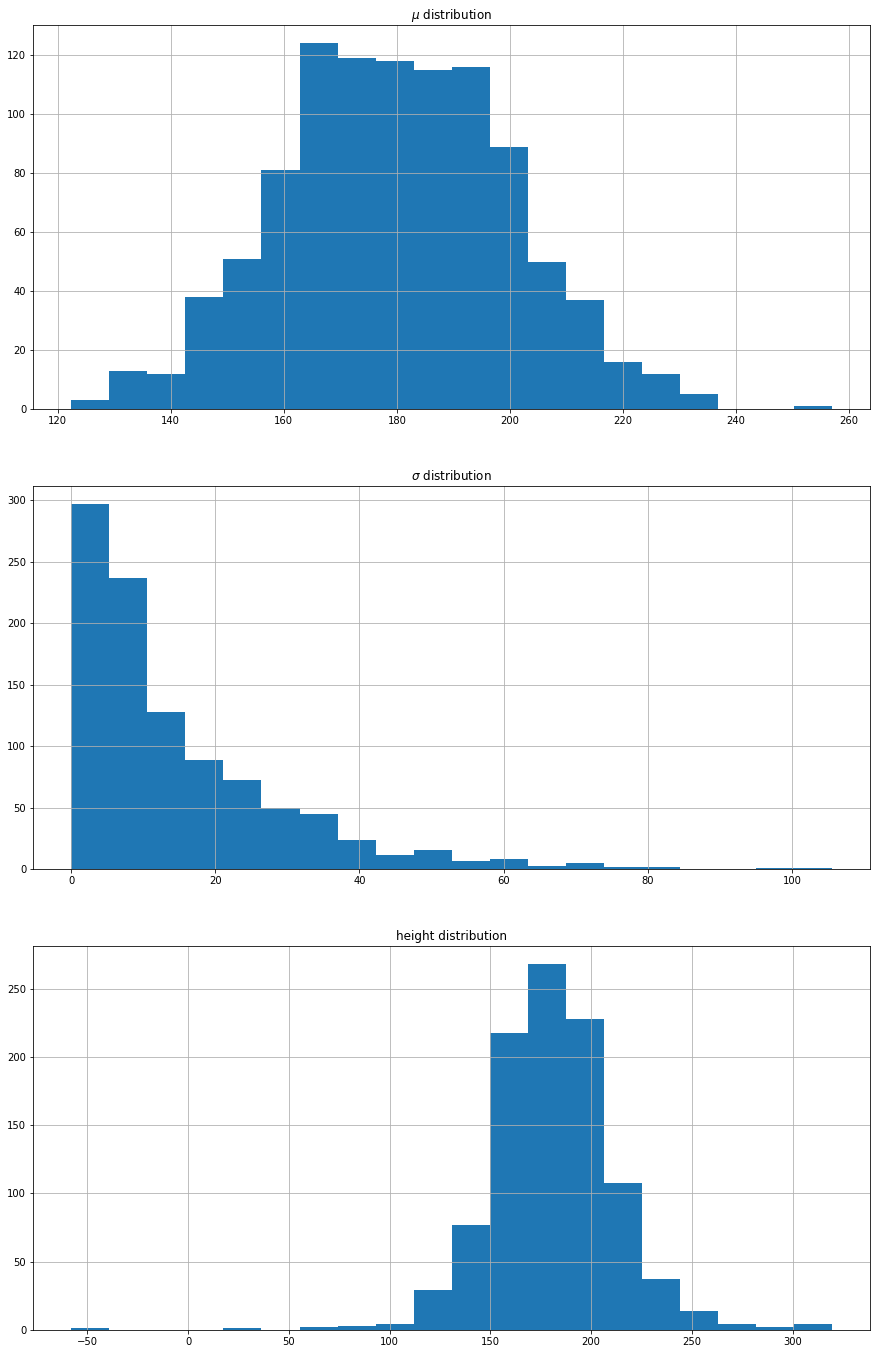

In [34]:
figure, ax = plt.subplots(nrows=3, figsize=(15,24))
ax[0].hist(df1['mu'], bins=20)
ax[0].set_title(r'$\mu$ distribution')
ax[0].grid()
ax[1].hist(df1['sigma'],bins=20)
ax[1].set_title(r'$\sigma$ distribution')
ax[1].grid()
ax[2].hist(df1['height'],bins=20)
ax[2].set_title(r'height distribution')
ax[2].grid()

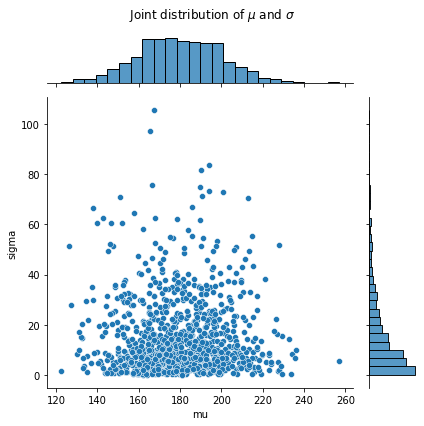

In [35]:
sns.jointplot(data=df1, x="mu", y="sigma")
plt.suptitle(r'Joint distribution of $\mu$ and $\sigma$')
plt.tight_layout()
plt.show()

INFO:cmdstanpy:compiling stan file /home/DA_2023/lab4/height_1_ppc.stan to exe file /home/DA_2023/lab4/height_1_ppc
INFO:cmdstanpy:compiled model executable: /home/DA_2023/lab4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


lp__  accept_stat__          mu       sigma      height
count  352.0          352.0  352.000000  352.000000  352.000000
mean     0.0            0.0  153.758338    3.310053  154.233705
std      0.0            0.0    5.154185    3.251307    7.526683
min      0.0            0.0  140.596000    0.007974  101.272000
25%      0.0            0.0  150.181000    0.958858  149.503500
50%      0.0            0.0  153.562500    2.199775  154.199500
75%      0.0            0.0  157.434750    4.771433  158.612250
max      0.0            0.0  167.541000   23.223700  185.657000

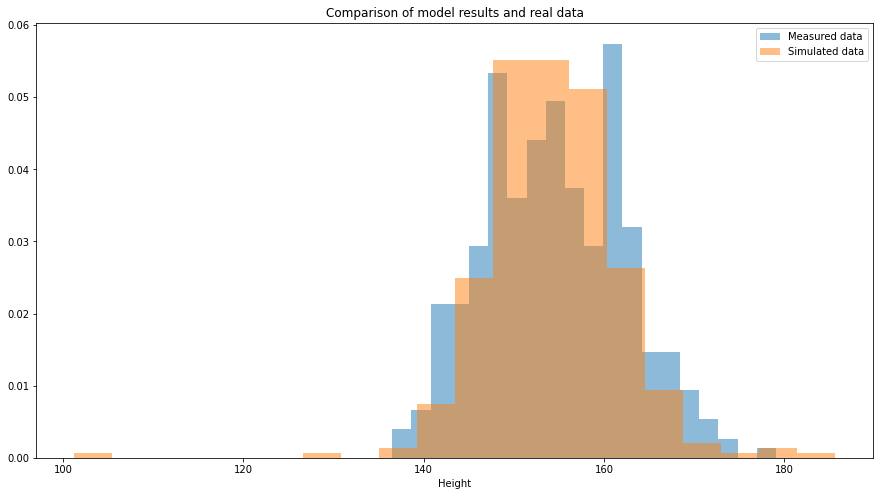

In [31]:
# model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

# R = 352
# sim=model_ppc.sample(iter_sampling=R,
#                      iter_warmup=0,
#                      chains=1,
#                      fixed_param=True,
#                      seed=29042020,refresh=R)
# df= sim.draws_pd()
# figure, ax = plt.subplots( figsize=(15,8))
# ax.hist(d["height"], bins=20, alpha=0.5, label="Measured data", density=True)
# ax.hist(df["height"], bins=20, alpha=0.5, label="Simulated data", density=True)
# plt.title("Comparison of model results and real data")
# plt.xlabel("Height")
# plt.legend()
# df.describe()

Prior prediction can model height. The histogram was prepared for mu~normal(155,5) and sigma~exponential(0.3). However the prior model has a lot more outlires, even thoight mean and standar deviation of simalated and observed data are similar. Maybe trying other distribution of sigma will give better results.

## Task 2. Model fit and evaluation

In [18]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [19]:
fit1=model_1_fit.sample(data=dict(N=len(d),
                        heights=d.height.values),
                        seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


In [23]:
df2 = pd.DataFrame(fit1.draws_pd())
df2.describe()

lp__  accept_stat__   stepsize__  treedepth__  n_leapfrog__  \
count  4000.000000    4000.000000  4000.000000  4000.000000   4000.000000   
mean   -896.167596       0.931788     0.840721     2.087000      4.151500   
std       0.972747       0.085058     0.051885     0.651949      2.027332   
min    -902.630000       0.457218     0.761281     1.000000      1.000000   
25%    -896.518250       0.899649     0.820194     2.000000      3.000000   
50%    -895.880500       0.964840     0.847973     2.000000      3.000000   
75%    -895.476750       0.995313     0.868499     3.000000      7.000000   
max    -895.210000       1.000000     0.905659     3.000000      7.000000   

       divergent__     energy__        sigma           mu       height  
count       4000.0  4000.000000  4000.000000  4000.000000  4000.000000  
mean           0.0   897.140449     7.764222   154.613072   154.392755  
std            0.0     1.371514     0.287620     0.404119     7.680238  
min            0.0   895.211000     6.882430   153.176000   126.792000  
25%            0.0   896.134000     7.568727   154.349000   149.246250  
50%            0.0   896.813500     7.749030   154.616000   154.472500  
75%            0.0   897.801000     7.945700   154.888000   159.580500  
max            0.0   905.402000     8.911650   156.010000   180.365000

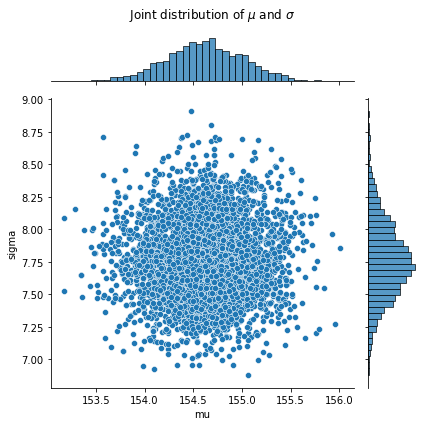

In [25]:
sns.jointplot(data=df2, x="mu", y="sigma")
plt.suptitle(r'Joint distribution of $\mu$ and $\sigma$')
plt.tight_layout()
plt.show()

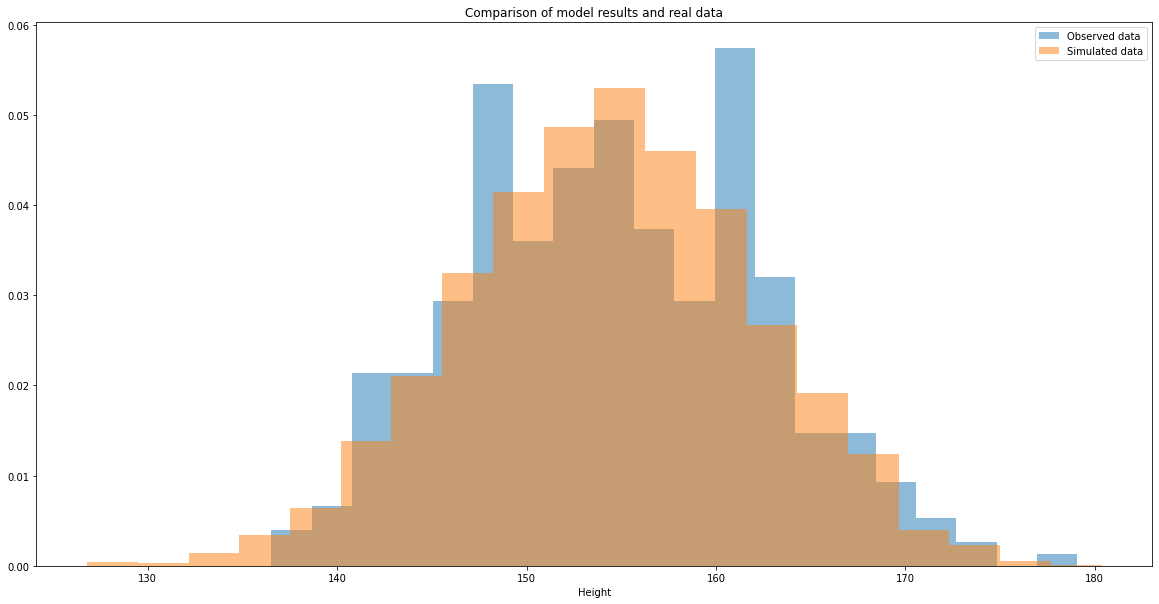

In [36]:
figure, ax = plt.subplots(figsize=(20,10))
ax.hist(d["height"], density=True, bins=20, alpha=0.5, label="Observed data")
ax.hist(df2["height"], density=True, bins=20, alpha=0.5, label="Simulated data")
plt.title("Comparison of model results and real data")
plt.xlabel("Height")
plt.legend()

he histogram shows that posterior prediction gives better results. There is no need to change model parameters, to better fit the data. 

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [37]:
d["c_weight"] = d["weight"].mean() - d["weight"]
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


## Task 4. Prior predictive checks
 

In [39]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim2=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

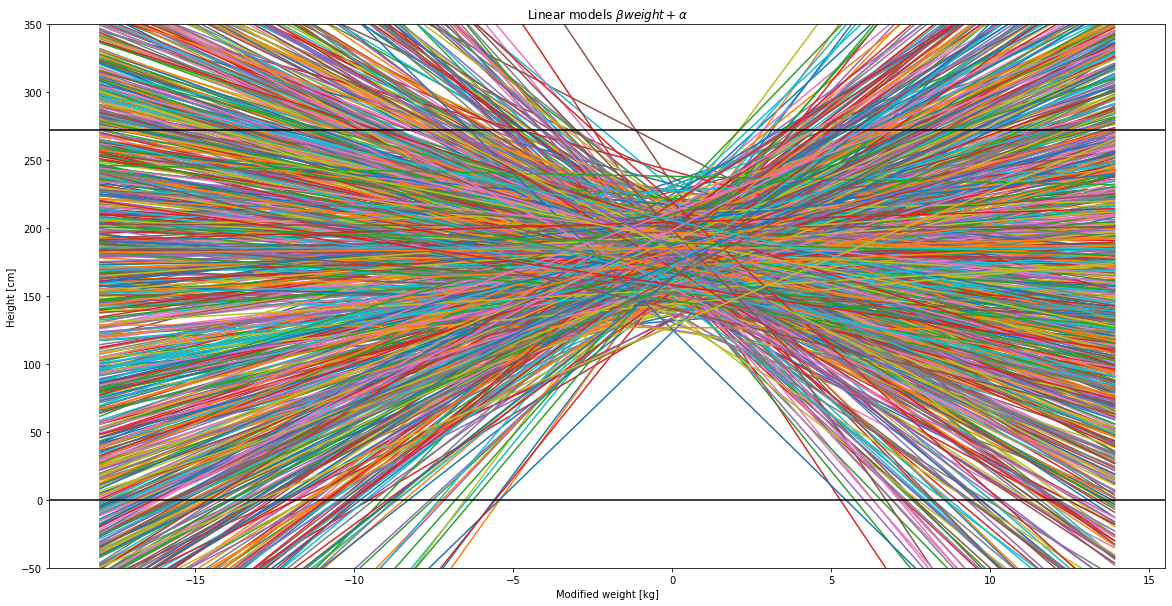

In [42]:
df3 = sim2.draws_pd()
df3.describe()

min_weight,max_weight = d.c_weight.min(),d.c_weight.max()

figure, ax = plt.subplots(figsize=(20,10))
ax.plot([min_weight,max_weight],[df3["alpha"]+df3["beta"]*min_weight, df3["alpha"]+df3["beta"]*max_weight])
ax.axhline(y=272, color='k')
ax.axhline(y=0, color='k')
ax.set_ylim(-50,350)
ax.set_title(r'Linear models $\beta weight+\alpha$')
ax.set_xlabel('Modified weight [kg]')
ax.set_ylabel('Height [cm]')
plt.show()

Black lines show minimum (0cm) and maximum (272cm) height. 
Only a small number of lines fall within the allowable range.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [43]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [44]:
sim3=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

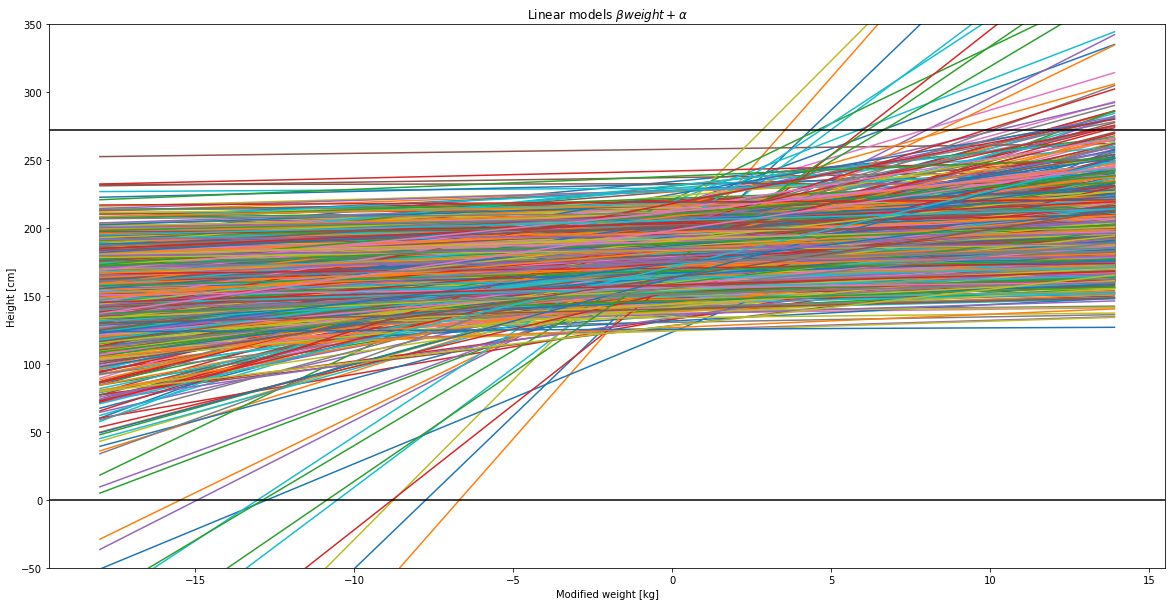

In [47]:
df4 = sim3.draws_pd()

figure, ax = plt.subplots(figsize=(20,10))
ax.plot([min_weight,max_weight],[df4["alpha"]+df4["beta"]*min_weight, df4["alpha"]+df4["beta"]*max_weight])
ax.axhline(y=272, color='k')
ax.axhline(y=0, color='k')
ax.set_ylim(-50,350)
ax.set_title(r'Linear models $\beta weight+\alpha$')
ax.set_xlabel('Modified weight [kg]')
ax.set_ylabel('Height [cm]')
plt.show()

The result, for lognormal distribution of beta, is much better. Only few lines are not consistent with minimum and maximum height.

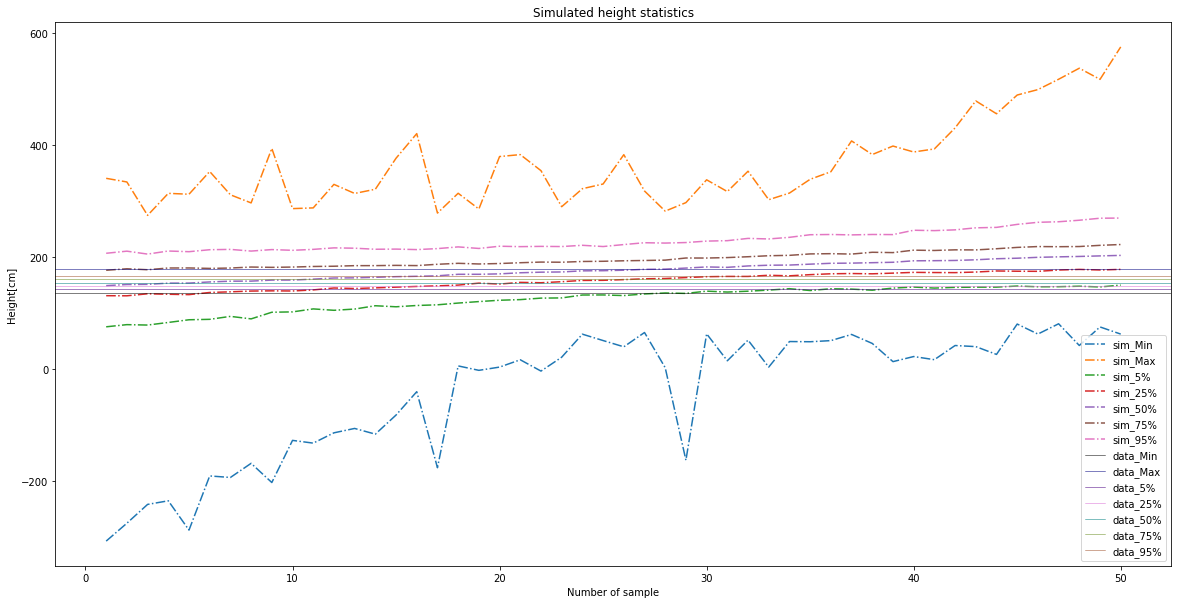

In [75]:
sim_stats = df4.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
sim_50 = sim_stats.loc[['mean']].iloc[:,5:]
sim_5 = sim_stats.loc[['5%']].iloc[:,5:]
sim_25 = sim_stats.loc[['25%']].iloc[:,5:]
sim_75 = sim_stats.loc[['75%']].iloc[:,5:]
sim_95 = sim_stats.loc[['95%']].iloc[:,5:]
sim_max = sim_stats.loc[['max']].iloc[:,5:]
sim_min = sim_stats.loc[['min']].iloc[:,5:]

x = np.linspace(1,50)

figure, ax = plt.subplots(figsize=(20,10))
ax.plot(x, sim_min.values.T, '-.', label="sim_Min")
ax.plot(x, sim_max.values.T, '-.', label="sim_Max")
ax.plot(x, sim_5.values.T, '-.', label="sim_5%")
ax.plot(x, sim_25.values.T, '-.', label="sim_25%")
ax.plot(x, sim_50.values.T, '-.', label="sim_50%")
ax.plot(x, sim_75.values.T, '-.', label="sim_75%")
ax.plot(x, sim_95.values.T, '-.', label="sim_95%")


data_stats = d.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])["height"].drop(["count","std"])

ax.axhline(y=data_stats.loc[['min']].iloc[0], linewidth=0.5, label='data_Min', color='black')
ax.axhline(y=data_stats.loc[['max']].iloc[0], linewidth=0.5, label='data_Max', color='navy')
ax.axhline(y=data_stats.loc[['5%']].iloc[0],  linewidth=0.5, label='data_5%', color='indigo')
ax.axhline(y=data_stats.loc[['25%']].iloc[0],  linewidth=0.5, label='data_25%', color='orchid')
ax.axhline(y=data_stats.loc[['50%']].iloc[0],  linewidth=0.5, label='data_50%', color='teal')
ax.axhline(y=data_stats.loc[['75%']].iloc[0],  linewidth=0.5, label='data_75%', color='olivedrab')
ax.axhline(y=data_stats.loc[['95%']].iloc[0],  linewidth=0.5, label='data_95%', color='sienna')

ax.set_ylabel('Height[cm]')
ax.set_xlabel('Number of sample')
ax.set_title('Simulated height statistics')
plt.legend()
plt.show()

Plot was prepared for height as the weight are input data to model.
Oberved data is possible within prior model, but not very likely. Simulated data is more widely spread out. Lines that represent maksimum, minimum and quantiles for real data are around model mean.

## Task 6. Fitting and evaluating model


In [63]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [64]:
N=50
data_fit = {'N': N, 'weight': d.c_weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status
chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)






chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)




chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


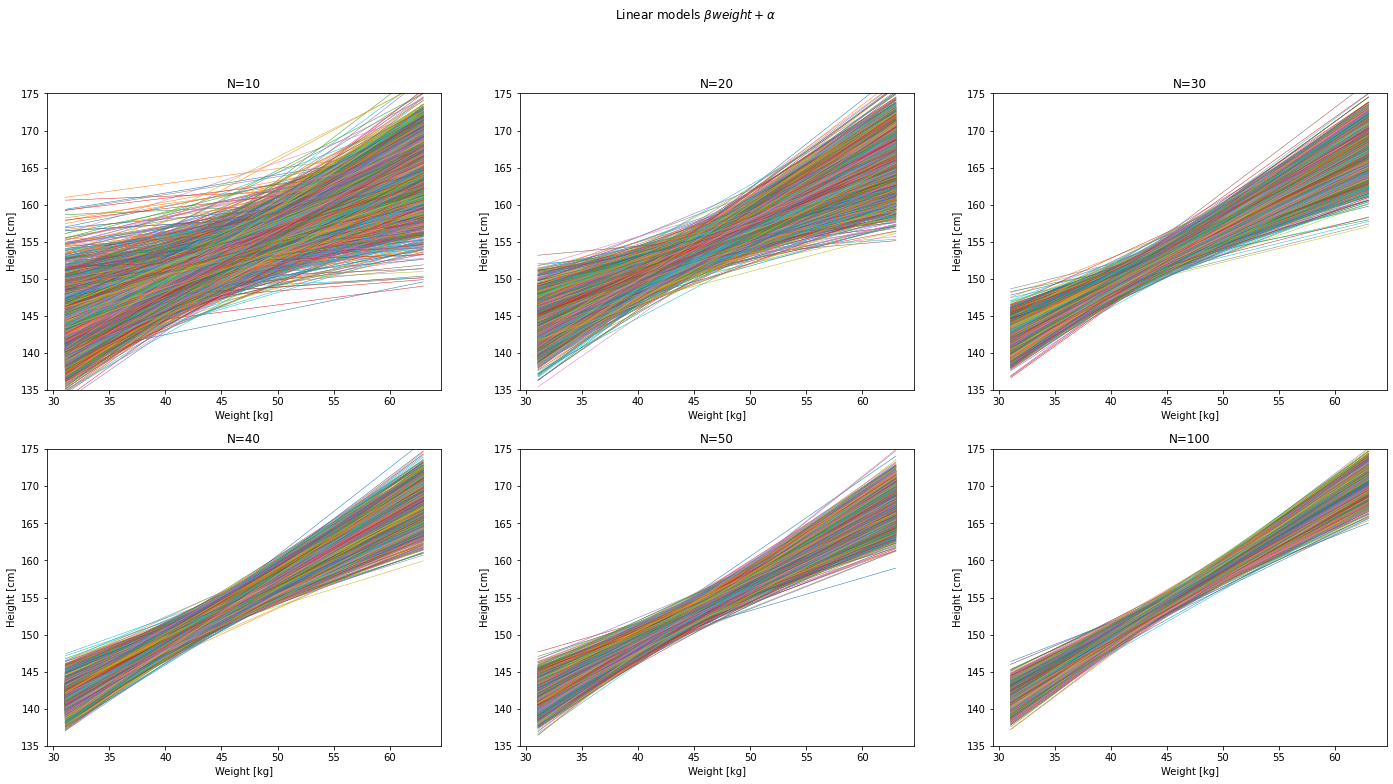

In [78]:
N_list = [10,20,30,40,50,100]
fig, ax = plt.subplots(2,3, figsize=(24,12))
fig.suptitle(r'Linear models $\beta weight+\alpha$')
for idx in range(len(N_list)):
    N = N_list[idx]
    data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    row = idx//3
    ax[row][idx-row*3].plot([d.weight.min(),d.weight.max()],[df["alpha"]+df["beta"]*d.weight.min(), df["alpha"]+df["beta"]*d.weight.max()],linewidth=0.5)
    ax[row][idx-row*3].set_ylim(135,175)
    ax[row][idx-row*3].set_title("N={0}".format(N))
    ax[row][idx-row*3].set_xlabel("Weight [kg]")
    ax[row][idx-row*3].set_ylabel("Height [cm]")

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed     


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed     

INFO:cmdstanpy:CmdStan done processing.


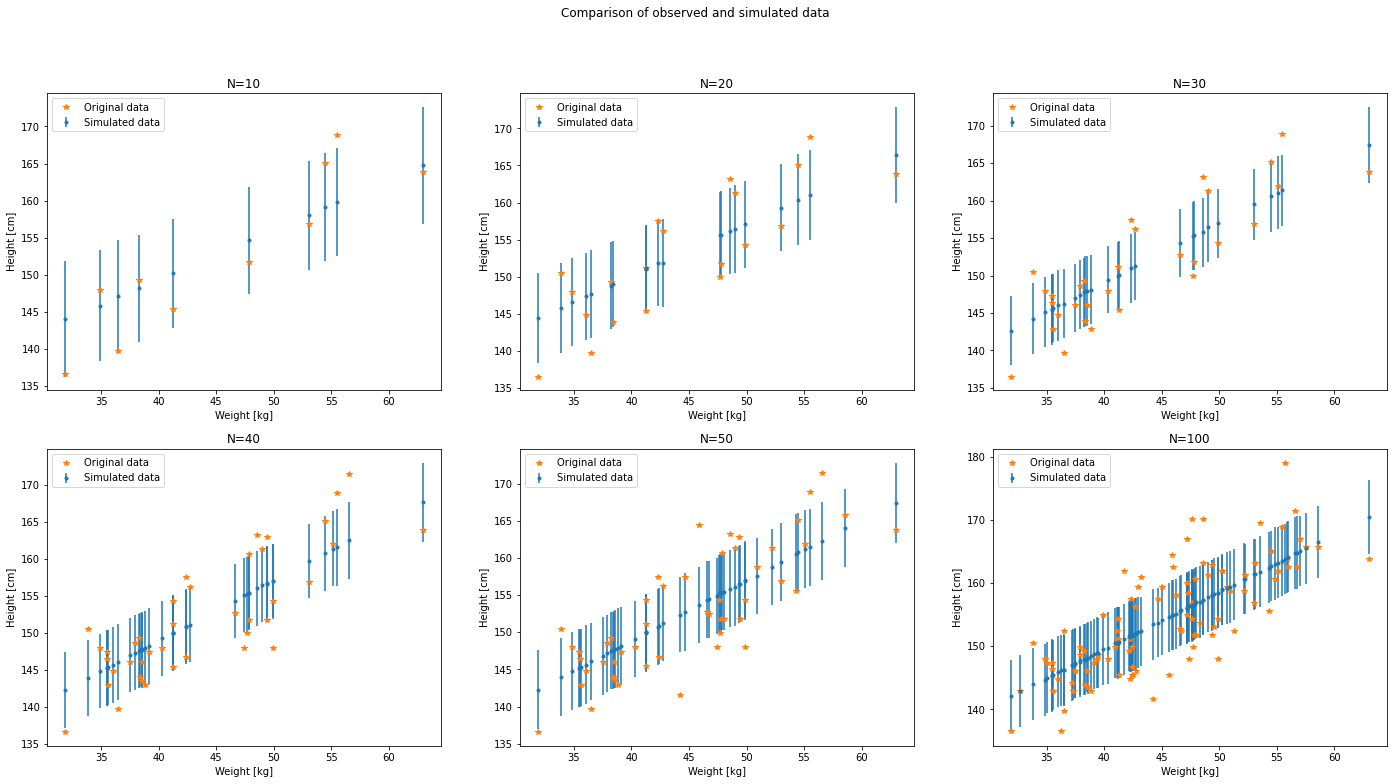

In [81]:
N_list = [10,20,30,40,50,100]
fig, ax = plt.subplots(2,3, figsize=(24,12))
fig.suptitle('Comparison of observed and simulated data')
for idx in range(len(N_list)):
    N = N_list[idx]
    data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    stats = df.describe()
    row = idx//3
    ax[row][idx-row*3].errorbar(d.weight.iloc[:N].values,stats.loc[["mean"]].iloc[:,-N:].to_numpy()[0], yerr=stats.loc[["std"]].iloc[:,-N:].to_numpy()[0], fmt='.', label="Simulated data")
    ax[row][idx-row*3].plot(d.weight.iloc[:N].values,d.height.iloc[:N].values, '*', label="Original data")
    ax[row][idx-row*3].set_title("N={0}".format(N))
    ax[row][idx-row*3].set_xlabel("Weight [kg]")
    ax[row][idx-row*3].set_ylabel("Height [cm]")
    ax[row][idx-row*3].legend(loc='upper left')

Increasing number of samples makes model more accurate. 

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       


chain 4 |██████████| 00:01 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Text(0, 0.5, 'Height [cm]')

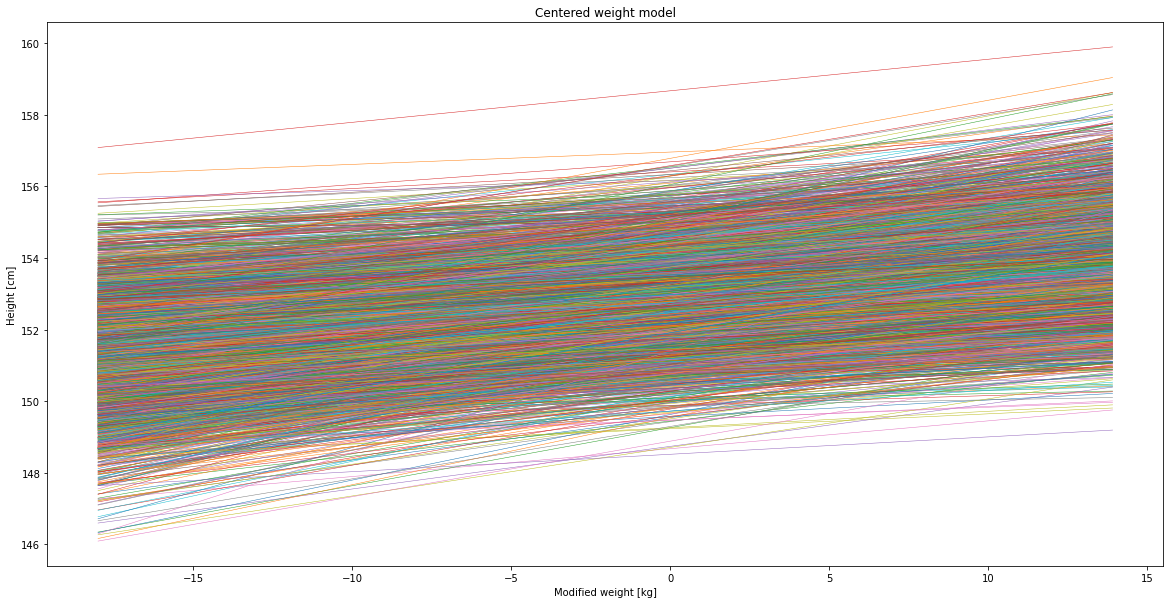

In [87]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')
N = 50
data_fit = {'N': N, 'weight': d.c_weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

df = fit.draws_pd()
figure, ax = plt.subplots(figsize=(20,10))
ax.plot([d.c_weight.min(),d.c_weight.max()],[df["alpha"]+df["beta"]*d.c_weight.min(), df["alpha"]+df["beta"]*d.c_weight.max()],linewidth=0.5)
ax.set_title("Centered weight model")
ax.set_xlabel("Modified weight [kg]")
ax.set_ylabel("Height [cm]")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


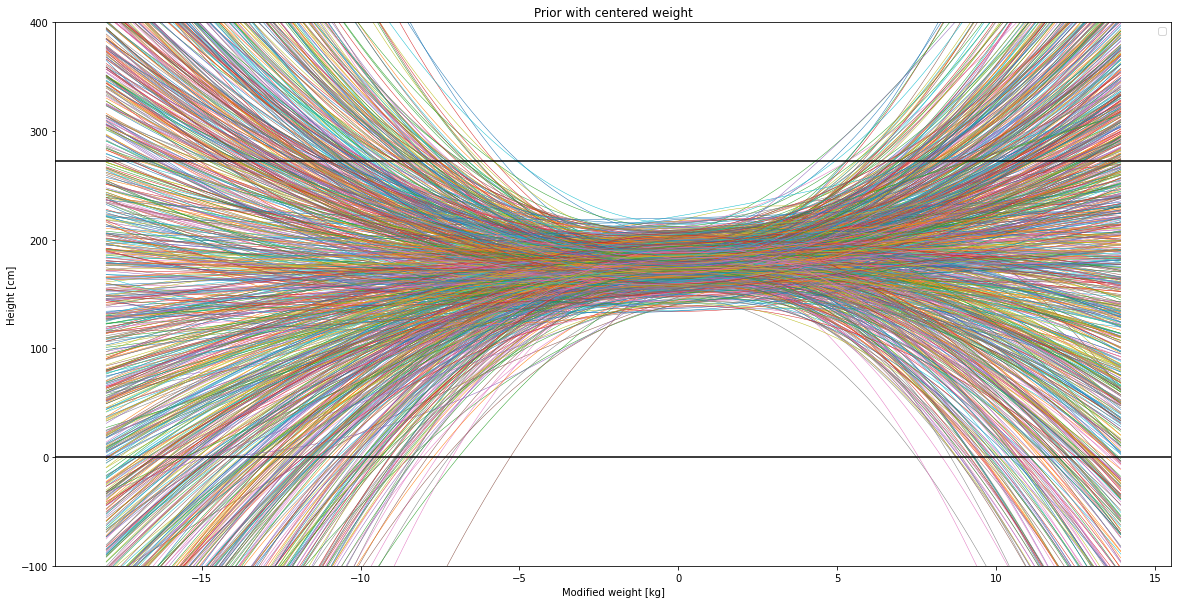

In [102]:
model_3_ppc=CmdStanModel(stan_file='ex7_ppc.stan')

R=1000
data_sim = data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sample = model_3_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

df_sample = sample.draws_pd()

x = np.linspace(d.c_weight.min(), d.c_weight.max(), 1000)


figure, ax = plt.subplots(figsize=(20,10))
for iter in range(1000):
    ax.plot(x, df_sample["alpha"][iter]+df_sample["beta"][iter]*x+df_sample["beta2"][iter]*(x**2),linewidth=0.5)

ax.axhline(y=272, color='k')
ax.axhline(y=0, color='k')
ax.set_ylim(-100,400)
ax.set_title("Prior with centered weight")
ax.set_xlabel("Modified weight [kg]")
ax.set_ylabel("Height [cm]")
ax.legend()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status
chain 1 |▉         | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |███████▎  | 00:05 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |████████▏ | 00:06 Iteration: 1500 / 2000 [ 75%]  (Sampling)



chain 1 |█████████▌| 00:06 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                       
chain 2 |██████████| 00:06 Sampling completed                       
chain 3 |██████████| 00:06 Sampling completed                       
chain 4 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


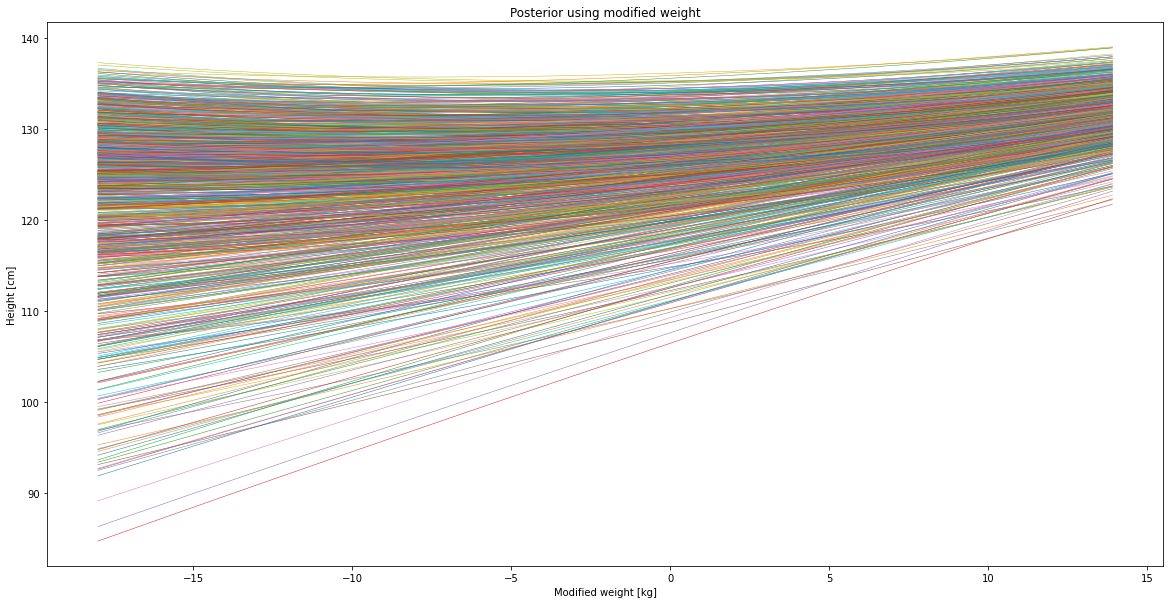

In [103]:
model_3_fit=CmdStanModel(stan_file='ex7_fit.stan')
N = 100
data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_3_fit.sample(data=data_fit,seed=28052020)

df_fit = fit.draws_pd()

figure, ax = plt.subplots(figsize=(20,10))
for iter in range(1000):
    ax.plot(x, df_fit["alpha"][iter]+df_fit["beta"][iter]*x+df_fit["beta2"][iter]*(x**2),linewidth=0.5)
ax.set_title("Posterior using modified weight")
ax.set_xlabel("Modified weight [kg]")
ax.set_ylabel("Height [cm]")
plt.show()



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status



chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)









chain 1 |█▎        | 00:02 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (S


INFO:cmdstanpy:CmdStan done processing.


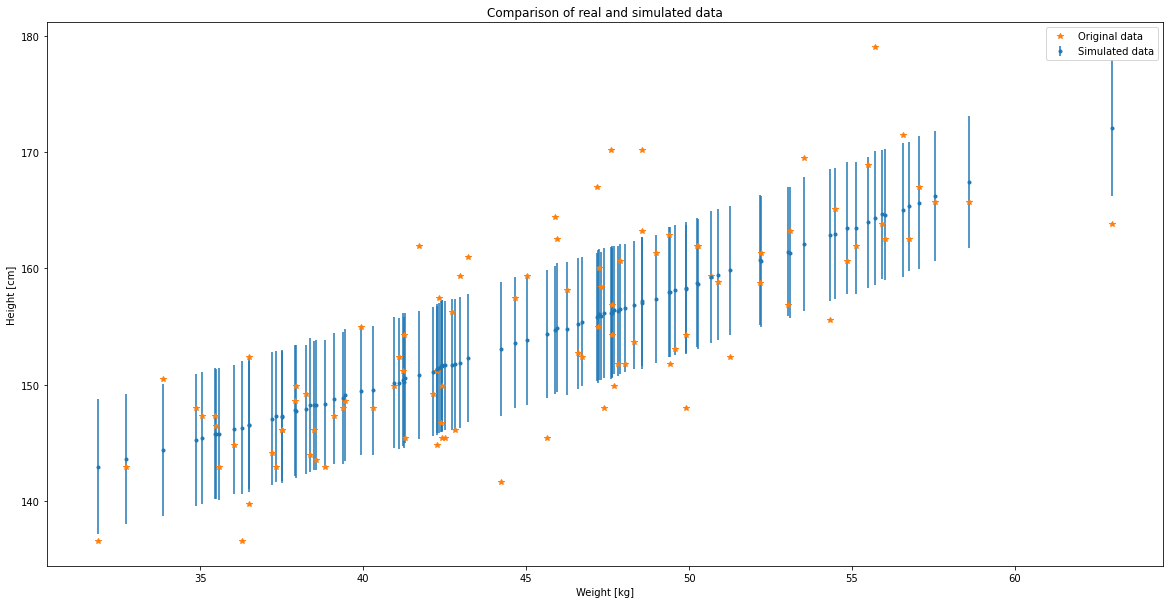

In [104]:
model_3_fit=CmdStanModel(stan_file='ex7_fit.stan')
N = 100
data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_3_fit.sample(data=data_fit,seed=28052020)

df_fit = fit.draws_pd()

df_fit = df_fit.describe()

figure, ax = plt.subplots(figsize=(20,10))
ax.errorbar(d.weight.iloc[:N].values,df_fit.loc[["mean"]].iloc[:,-N:].to_numpy()[0], yerr=df_fit.loc[["std"]].iloc[:,-N:].to_numpy()[0], fmt='.', label="Simulated data")
ax.plot(d.weight.iloc[:N].values,d.height.iloc[:N].values, '*', label="Original data")
ax.legend()
ax.set_title("Comparison of real and simulated data")
ax.set_xlabel("Weight [kg]")
ax.set_ylabel("Height [cm]")
plt.show()

Model based on polynominal regression is good for prediction adults heights. 